In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_values = pd.read_csv("../data/training_set_values.csv")
train_labels = pd.read_csv("../data/training_set_labels.csv")

In [3]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [4]:
train_values.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [5]:
df = train_values.merge(train_labels)

## Date Recorded

In [6]:
df["date_recorded"] = pd.to_datetime(df["date_recorded"])

In [7]:
df["date_recorded"].max()

Timestamp('2013-12-03 00:00:00')

In [8]:
df["date_recorded"].min()

Timestamp('2002-10-14 00:00:00')

## Scheme Management

In [9]:
df["scheme_management"].isna().sum()

3877

In [10]:
df["scheme_management"].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [11]:
df["scheme_management"] = df["scheme_management"].fillna("None")

In [12]:
df["scheme_management"].isna().sum()

0

## Scheme Name

In [13]:
df["scheme_name"].isna().sum()

28166

In [14]:
df["scheme_name"].value_counts()

K                                   682
None                                644
Borehole                            546
Chalinze wate                       405
M                                   400
                                   ... 
Mashati Dispensary  water supply      1
Mweka                                 1
Kibonge Water Supply                  1
Nyabugugo spring source               1
Kifaru Water Supply                   1
Name: scheme_name, Length: 2696, dtype: int64

In [15]:
df["scheme_name"].isna().sum()

28166

## Scheme Management vs. Name

These categories are described identically in the dataframe description. Are they both useful?

In [16]:
df.loc[df['scheme_management'] == "VWC"]["scheme_name"].value_counts()

K                                571
DANIDA                           378
M                                331
Borehole                         285
Government                       249
                                ... 
Mondoros water scheme              1
Mtir                               1
Nyamwa/kesangura water suplly      1
Pande plot Water supply            1
Mulu                               1
Name: scheme_name, Length: 1861, dtype: int64

## Permit

In [17]:
df["permit"].isna().sum()

3056

In [18]:
df["permit"].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [19]:
df.loc[df['permit'] == True]["status_group"].value_counts(normalize=True)

functional                 0.554437
non functional             0.376145
functional needs repair    0.069417
Name: status_group, dtype: float64

In [20]:
df.loc[df['permit'] == False]["status_group"].value_counts(normalize=True)

functional                 0.517094
non functional             0.407443
functional needs repair    0.075463
Name: status_group, dtype: float64

In [21]:
df.loc[(df['permit'] != True)&(df['permit'] != False)]["status_group"].value_counts(normalize=True)

functional                 0.547448
non functional             0.354385
functional needs repair    0.098168
Name: status_group, dtype: float64

In [22]:
df.loc[(df['permit'] != True)&(df['permit'] != False), "permit"] = "Unknown"

In [23]:
df["permit"].value_counts()

True       38852
False      17492
Unknown     3056
Name: permit, dtype: int64

The wells with missing data in this column are unlike both the permitted and unpermitted wells: they are more likely to be in need of repair than either other set, while they have the fewest non-functional wells. As such, we'll use this as a distinct third group.

## Location

Finding missing coordinates to aid in visualization

In [24]:
df.loc[df['longitude'] == 0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
21,6091,0.0,2013-02-10,Dwsp,0,DWE,0.0,-2.000000e-08,Muungano,0,...,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump,functional
53,32376,0.0,2011-08-01,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Polisi,0,...,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
168,72678,0.0,2013-01-30,Wvt,0,WVT,0.0,-2.000000e-08,Wvt Tanzania,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
177,56725,0.0,2013-01-17,Netherlands,0,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
253,13042,0.0,2012-10-29,Hesawa,0,DWE,0.0,-2.000000e-08,Kwakisusi,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,0.0,2011-07-18,Dwsp,0,DWE,0.0,-2.000000e-08,Wazazo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59208,3631,0.0,2013-01-22,Dwsp,0,DWE,0.0,-2.000000e-08,Mtakuja,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59295,60843,0.0,2011-07-19,Rwssp,0,DWE,0.0,-2.000000e-08,Maendeleo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59324,748,0.0,2013-01-22,World Vision,0,World Vision,0.0,-2.000000e-08,Mwazwilo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [25]:
df.loc[df['longitude'] == 0]["ward"].value_counts()

Chinamili      111
Nkololo         80
Somanda         72
Bumera          71
Kalangalala     66
              ... 
Nyugwa           4
Bukondo          2
Shabaka          2
Nkome            2
Senga            1
Name: ward, Length: 69, dtype: int64

In [26]:
coords = {"Chinamili":(-2.8732, 34.2205),
      "Nkololo":(-2.6419, 34.1601),
      "Somanda":(-3.3667, 33.9500),
      "Bumera":(-1.2844, 34.3251),
      "Kalangalala":(-2.8706, 32.2367),
      "Nkoma":(-3.5749, 34.3829),
      "Mkula":(-2.3000, 33.8833),
      "Nkungulu":(-3.0086, 33.4164),
      "Sakwe":(-2.7677, 33.8630),
      "Nyang'hwale":(-3.0856, 32.6277),
      "Kasamwa":(-2.8385, 32.4212),
      "Sapiwi":(-2.3684, 33.9655),
      "Lugulu":(-2.9141, 33.9583),
      "Mwamapalala":(-3.0165, 33.9138),
      "Kharumwa":(-3.2004, 32.6578),
      "Igalukilo":(-2.3759, 33.7987),
      "Kinang'weli":(-2.9438, 33.7441),
      "Kasoli":(-2.5695, 33.6712),
      "Nyakabindi":(-2.6410, 33.9903),
      "Zagayu":(-2.9655, 33.8096),
      "Mwadobana":(-2.5317, 34.0500),
      "Malili":(-2.4463, 33.8057),
      "Bunamhala":(-2.8534, 34.0623),
      "Lubanga":(-2.6320, 32.4018),
      "Nyaluhande":(-2.5004, 33.6108),
      "Mhango":(-2.7529, 33.9165),
      "Lagangabilili":(-2.9599, 34.1366),
      "Bukoli":(-3.1964, 32.3227),
      "Dutwa":(-2.5098, 33.9680),
      "Kakora":(-2.9657, 33.3346),
      "Mbita":(-2.8447, 33.7874),
      "Kalemela":(-2.2988, 33.7428),
      "Ikungulyabashashi":(-2.6080, 33.9491),
      "Busolwa":(-3.0024, 32.6309),
      "Mwingiro":(-3.1447, 32.5014),
      "Mwaswale":(-2.7824, 34.3522),
      "Kabita":(-2.3204, 33.6698),
      "Katoro":(-3.0062, 31.9271),
      "Gamboshi":(-2.6055, 33.7681),
      "Mhunze":(-3.6195, 33.8128),
      "Badugu":(-2.4667, 33.6500),
      "Mwananyili":(-6.788, 39.256),
      "Mwaubingi":(-2.5223, 34.1136),
      "Chigunga":(-2.8140, 31.9338),
      "Shigala":(-2.3924, 33.6763),
      "Bariadi":(-2.8070, 33.9917),
      "Kagu":(-2.7274, 32.0121),
      "Kiloleli":(-2.4909, 32.9206),
      "Nyachiluluma":(-2.7818, 31.9197),
      "Nzera":(-2.5214, 32.1561),
      "Bukwimba":(-3.3367, 32.6066),
      "Mtakuja":(-3.4868, 37.3573),
      "Nyamalimbe":(-3.0819, 32.3671),
      "Nyakamwaga":(-2.9873, 32.2308),
      "Kaseme":(-3.1270, 31.9495),
      "Kamena":(-3.0724, 32.3249),
      "Sagata":(-2.7446, 34.2375),
      "Ngasamo":(-2.4900, 33.8442),
      "Lwamgasa":(-3.1166, 32.0417),
      "Kafita":(-3.2349, 32.5852),
      "Nyakagomba":(-2.8697, 31.9421),
      "Ihanamilo":(-2.9501, 32.2677),
      "Kamhanga":(-2.7346, 32.3087),
      "Busanda":(-3.0187, 32.1119),
      "Nyugwa":(-3.2237, 32.7380),
      "Nkome":(-2.5009, 32.0083),
      "Shabaka":(-2.9942, 32.4536),
      "Bukondo":(-2.6712, 31.9189),
      "Senga":(-4.4000, 34.6667)}

In [27]:
#Sanity check
missing_coords = list(df.loc[df['longitude'] == 0]["ward"].value_counts().keys())
missing_coords == list(coords.keys())

False

In [28]:
def get_lat(x):
    return coords[x][0]
def get_long(x):
    return coords[x][1]

In [29]:
df_miss = df.loc[df['longitude'] == 0]

In [30]:
df.loc[(df.longitude == 0), 'latitude'] = df_miss["ward"].apply(get_lat)
df.loc[(df.longitude == 0), 'longitude'] = df_miss["ward"].apply(get_long)

In [31]:
df.loc[df['longitude'] == df["longitude"].max()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
735,39105,5.0,2013-02-16,Fini Water,-36,Fini water,40.345193,-10.495785,Mwemberadu,0,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional


# Exploring

In [32]:
df["funder"].isna().sum()

3635

In [33]:
df["funder"].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Sophia Wazir                 1
Iado                         1
Getekwe                      1
Kamata Project               1
Agape Churc                  1
Name: funder, Length: 1897, dtype: int64

In [34]:
df.loc[df["funder"].isna()]["status_group"].value_counts(normalize=True)

functional                 0.544979
non functional             0.334801
functional needs repair    0.120220
Name: status_group, dtype: float64

In [35]:
df["management"].isna().sum()

0

In [36]:
df["management"].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [37]:
df["management_group"].isna().sum()

0

In [38]:
df["management_group"].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [39]:
df.loc[df["management_group"] == "commercial"]["management"].value_counts()

private operator    1971
water authority      904
company              685
trust                 78
Name: management, dtype: int64

In [40]:
df.loc[df["management_group"] == "user-group"]["management"].value_counts()

vwc            40507
wug             6515
water board     2933
wua             2535
Name: management, dtype: int64

Differences:

    1. Parastatal matches
    2. "other" is split into "other" and "other - school"
    3. "unknown" matches
    4. "commercial" is split into "private operator," "water authority," "company," and "trust"
    5. "user-group" is split into "vwc," "wug," "water board," and "wua"

## Installer

In [41]:
df["installer"].isna().sum()

3655

In [42]:
df["status_group"].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [43]:
df.loc[df["installer"].isna()]["status_group"].value_counts(normalize=True)

functional                 0.547196
non functional             0.332421
functional needs repair    0.120383
Name: status_group, dtype: float64

In [44]:
df.loc[df["installer"] == "unknown"]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
14157,49450,0.0,2011-03-06,Unknown,83,unknown,38.996737,-7.359257,Kwa Pazi,0,...,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,non functional


In [45]:
df.loc[df["installer"] == "Unknown"]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
28777,27916,0.0,2013-01-28,Unknown,1827,Unknown,35.551862,-3.893966,Kwa Andrea Mao,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
28881,53420,0.0,2011-03-23,Unknown,74,Unknown,39.219746,-7.300187,Shuleni,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
40947,34315,0.0,2013-01-28,Unknown,1744,Unknown,35.539506,-3.832108,Kwa John Boai,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [46]:
list(df["installer"].unique())

['Roman',
 'GRUMETI',
 'World vision',
 'UNICEF',
 'Artisan',
 'DWE',
 'DWSP',
 'Water Aid',
 'Private',
 'DANIDA',
 'Lawatefuka water sup',
 'WEDECO',
 'Danid',
 'TWE',
 'ISF',
 'Kilolo Star',
 'District council',
 'Water',
 'WU',
 nan,
 'Not known',
 'Central government',
 'CEFA',
 'Commu',
 'Accra',
 'World Vision',
 'LGA',
 'MUWSA',
 'KKKT _ Konde and DWE',
 'Government',
 'Olgilai village community',
 'KKKT',
 'RWE',
 'Adra /Community',
 'SEMA',
 'SHIPO',
 'HESAWA',
 'ACRA',
 'Community',
 'IFAD',
 'Sengerema Water Department',
 'HE',
 'ISF and TACARE',
 'Kokeni',
 'DA',
 'Adra',
 'ALLYS',
 'AICT',
 'KIUMA',
 'CES',
 'District Counci',
 'Ruthe',
 'Adra/Community',
 'Tulawaka Gold Mine',
 'KKT C',
 'Hesawa',
 'Water board',
 'LOCAL CONTRACT',
 'WFP',
 'LIPS',
 'TASAF',
 'World',
 '0',
 'SW',
 'Shipo',
 'Fini water',
 'Kanisa',
 'OXFARM',
 'VILLAGE COUNCIL Orpha',
 'Villagers',
 'Idara ya maji',
 'FPCT',
 'WVT',
 'Ir',
 'DANID',
 'Angli',
 'secondary school',
 'Amref',
 'JBG',
 'DAD

## Funder

In [47]:
df["funder"].isna().sum()

3635

In [48]:
df["funder"].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Sophia Wazir                 1
Iado                         1
Getekwe                      1
Kamata Project               1
Agape Churc                  1
Name: funder, Length: 1897, dtype: int64

In [49]:
list(df["funder"].unique())

['Roman',
 'Grumeti',
 'Lottery Club',
 'Unicef',
 'Action In A',
 'Mkinga Distric Coun',
 'Dwsp',
 'Rwssp',
 'Wateraid',
 'Isingiro Ho',
 'Private',
 'Danida',
 'World Vision',
 'Lawatefuka Water Supply',
 'Biore',
 'Rudep',
 'Hesawa',
 'Twe',
 'Isf',
 'African Development Bank',
 'Government Of Tanzania',
 'Sobodo',
 'Water',
 'Private Individual',
 'Undp',
 nan,
 'Not Known',
 'Kirde',
 'Cefa',
 'Ces(gmbh)',
 'European Union',
 'Lga',
 'District Council',
 'Muwsa',
 'Dwe/norad',
 'Kkkt_makwale',
 'Sawaka',
 'Ces (gmbh)',
 'Olgilai Village Community',
 'Kkkt',
 'Roman Catholic',
 'Norad',
 'Adra',
 'Sema',
 'Piusi',
 'Dwe',
 'Rc Church',
 'Swisland/ Mount Meru Flowers',
 'Ifad',
 'Swedish',
 'Idc',
 'He',
 'Isf/tacare',
 'Jica',
 'Mzee Sh',
 'Aict',
 'Tcrs',
 'Kiuma',
 'Germany Republi',
 'Netherlands',
 'Ruthe',
 'Tulawaka Gold Mine',
 'Nethalan',
 'Tasaf',
 'Concern World Wide',
 'Wfp',
 'Lips',
 'Sida',
 'World Bank',
 'Tanza',
 '0',
 'Sw',
 'Shipo',
 'Fini Water',
 'Kanisa',
 'Ox

## Feature Importance Visualizations

In [51]:
df["quantity"].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [52]:
df.loc[df["quantity"] == "insufficient"]["status_group"].value_counts()

functional                 7916
non functional             5763
functional needs repair    1450
Name: status_group, dtype: int64

In [53]:
quan_labels = ['enough', 'seasonal', 'insufficient', 'dry', 'unknown']

quan_func = []
quan_nonfunc = []
quan_func_need_repair = []

for label in quan_labels:
    counts = df.loc[df["quantity"] == label]["status_group"].value_counts(normalize=True)
    quan_func.append(counts["functional"]*100)
    quan_nonfunc.append(counts["non functional"]*100)
    quan_func_need_repair.append(counts["functional needs repair"]*100)

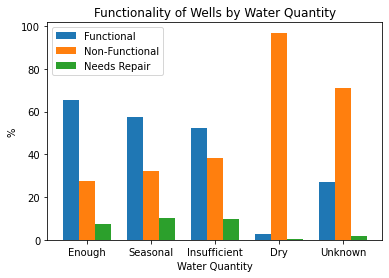

In [71]:
x = np.arange(len(quan_labels))
width = 0.25

fig, ax = plt.subplots()

r1 = np.arange(len(quan_func))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

ax.bar(r1, quan_func, width, label='Functional')
ax.bar(r2, quan_nonfunc, width, label='Non-Functional')
ax.bar(r3, quan_func_need_repair, width, label='Needs Repair')

ax.set_ylabel('%')

ax.set_title('Functionality of Wells by Water Quantity')
ax.set_xlabel('Water Quantity')

plt.xticks([r + width for r in range(len(quan_func))], ['Enough', 'Seasonal', 'Insufficient', 'Dry', 'Unknown'])
ax.legend();

# plt.savefig("../Images/quantity.png", dpi=600, transparent=True);

In [55]:
df["extraction_type"].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [56]:
df.loc[df["extraction_type"] == "gravity"]["status_group"].value_counts(normalize=True)

functional                 0.599253
non functional             0.299888
functional needs repair    0.100859
Name: status_group, dtype: float64

In [57]:
ext_labels = ['gravity', 'nira/tanira', 'submersible', 'swn 80', 'other']

ext_func = []
ext_nonfunc = []
ext_func_need_repair = []

for label in ext_labels:
    counts = df.loc[df["extraction_type"] == label]["status_group"].value_counts(normalize=True)
    ext_func.append(counts["functional"]*100)
    ext_nonfunc.append(counts["non functional"]*100)
    ext_func_need_repair.append(counts["functional needs repair"]*100)

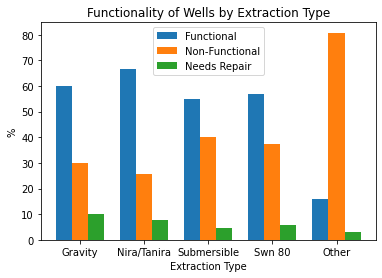

In [58]:
x = np.arange(len(ext_labels))
width = 0.25

fig, ax = plt.subplots()

r1 = np.arange(len(ext_func))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

ax.bar(r1, ext_func, width, label='Functional')
ax.bar(r2, ext_nonfunc, width, label='Non-Functional')
ax.bar(r3, ext_func_need_repair, width, label='Needs Repair')

ax.set_ylabel('%')
ax.set_title('Functionality of Wells by Extraction Type')
ax.set_xlabel('Extraction Type')
plt.xticks([r + width for r in range(len(ext_func))], ['Gravity', 'Nira/Tanira', 'Submersible', 'Swn 80', 'Other'])
ax.legend();

# plt.savefig("../Images/extraction_type.png", dpi=600, transparent=True);

In [59]:
df["payment"].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [60]:
df.loc[df["payment"] == "never pay"]["status_group"].value_counts(normalize=True)

non functional             0.475856
functional                 0.448911
functional needs repair    0.075233
Name: status_group, dtype: float64

In [61]:
pay_labels = ['pay per bucket', 'pay monthly', 'pay when scheme fails', 'never pay', 'unknown']

pay_func = []
pay_nonfunc = []
pay_func_need_repair = []

for label in pay_labels:
    counts = df.loc[df["payment"] == label]["status_group"].value_counts(normalize=True)
    pay_func.append(counts["functional"]*100)
    pay_nonfunc.append(counts["non functional"]*100)
    pay_func_need_repair.append(counts["functional needs repair"]*100)

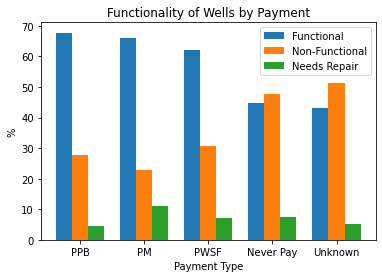

In [62]:
x = np.arange(len(pay_labels))
width = 0.25

fig, ax = plt.subplots()

r1 = np.arange(len(pay_func))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

ax.bar(r1, pay_func, width, label='Functional')
ax.bar(r2, pay_nonfunc, width, label='Non-Functional')
ax.bar(r3, pay_func_need_repair, width, label='Needs Repair')

ax.set_ylabel('%')
ax.set_title('Functionality of Wells by Payment')
ax.set_xlabel('Payment Type')
plt.xticks([r + width for r in range(len(pay_func))], ['PPB', 'PM', 'PWSF', 'Never Pay', 'Unknown'],)
ax.legend();

# plt.savefig("../Images/payment.png", dpi=600, bbox_inches="tight", transparent=True);